# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# data processing libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time

# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

# delete empty columns
del azdias['Unnamed: 0']
del customers['Unnamed: 0']

<string>:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 1min 34s


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


**DataFrame sizes**

In [5]:
print("AZDIAS dataframe size\nrows: {}\ncols: {}".format(*azdias.shape))

AZDIAS dataframe size
rows: 891221
cols: 366


In [6]:
print("CUSTOMERS dataframe size\nrows: {}\ncols: {}".format(*customers.shape))

CUSTOMERS dataframe size
rows: 191652
cols: 369


### 0.1 Load DataFrame with information about all attributes

1. read `DIAS Attributes - Values 2017.xlsx` file into pandas DataFrame,
2. iterate over rows, read each unique attributes name and add meanings and value  rows into new lists,
3. read `DIAS Information Levels - Attributes 2017.xlsx` file into pandas DataFrame,
4. join both DataFrames on Attribute and Description columns into one DataFrame.

In [7]:
# 1. read `DIAS Attributes - Values 2017.xlsx` file into pandas DataFrame
df_attr_1 = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
del df_attr_1['Unnamed: 0']
df_attr_1.head(6)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown


In [8]:
# 2. iterate over rows, read each attributes name, description and value meanings,
rows = list()
start = False
for idx in df_attr_1.index:
    if df_attr_1.iloc[idx].Attribute is not np.nan:
        if start:
            rows.append([attribute, description, values, meanings])
        # create lists to store Values and Meanings
        values = list()
        meanings = list()
        # read data
        attribute = df_attr_1.iloc[idx].Attribute
        description = df_attr_1.iloc[idx].Description
        # just quick and ungly way to skip saving the first row
        start = True
        
    # add values and meanings to the lists
    values.append(df_attr_1.iloc[idx].Value)
    meanings.append(df_attr_1.iloc[idx].Meaning)
    
rows.append([attribute, description, values, meanings])

df_attr_1 = pd.DataFrame(rows, columns=["Attribute", "Description", "Values", "Meanings"])
df_attr_1.head()

,Attribute,Description,Values,Meanings
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ..."
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y..."
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ..."
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]"
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)]


In [9]:
# 3. read DIAS Information Levels - Attributes 2017.xlsx file into pandas DataFrame
df_attr_2 = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
del df_attr_2['Unnamed: 0']
df_attr_2.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


There are 5 attribute names which were written in inconvienient manner:

* `D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24`,
* `D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24`,
* `D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24`,
* `D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24`,
* `D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24`.

These attributes will be manually fixed in cells bellow.

In [10]:
attr_list = ["D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24",
            "D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24",
            "D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24",
            "D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24",
            "D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24"]

# get rows of attributes of interest into new DataFrame
df_attr_3 = df_attr_2[df_attr_2.Attribute.isin(attr_list)]

# remove those attribrutes from DataFrame 
df_attr_2 = df_attr_2[~df_attr_2.Attribute.isin(attr_list)]

# check new DataFrame
df_attr_3.head()

,Information level,Attribute,Description,Additional notes
50,NaN,D19_GESAMT_ANZ_12 ...,transaction activity TOTAL POOL in the last 12...,NaN
51,NaN,D19_BANKEN_ ANZ_12 D19_BANKEN_ ANZ_24,transaction activity BANKS in the last 12 and ...,NaN
52,NaN,D19_TELKO_ ANZ_12 D19_TELKO_ ...,transaction activity TELCO in the last 12 and ...,NaN
53,NaN,D19_VERSI_ ANZ_12 ...,transaction activity INSURANCE in the last 12 ...,NaN
54,NaN,D19_VERSAND_ ANZ_12 D19_VERSAND_ ANZ_24,transaction activity MAIL-ORDER in the last 12...,NaN


Creating a function which splits string into new strings was not an option because `D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24` would have two new strings `D19_GESAMT_ANZ_12` and `D19_GESAMT_ANZ_24`, but other attributes like `D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24` would result in 4 new strings `D19_BANKEN_`, `ANZ_12`, `D19_BANKEN_` and `ANZ_24`. Therefore I chose to just manualy iterate over rows and resave them into list, then pandas DataFrame.

In [11]:
# temprarry list to store data
_data = list()

for idx in df_attr_3.index:
    # split decription value with large space
    attributes = df_attr_3.loc[idx].Attribute.split("          ")
    # remove unneccesary spaces
    attribute_12 = attributes[0].replace(" ", "")
    attribute_24 = attributes[-1].replace(" ", "")
    
    # split decription value with " and "
    description = df_attr_3.loc[idx].Description.split(" and ")
    # create new descriptions for 12 and 24 months
    description_12 = description[0] + " months"
    description_24 = description[0][:-2] + description[1]
    
    # add information about 12 month attribute
    _data.append([np.nan, attribute_12, description_12, np.nan])
    # add information about 24 month attribute
    _data.append([np.nan, attribute_24, description_24, np.nan])
    
    
# resave data into DataFrame
df_attr_3 = pd.DataFrame(_data, columns=df_attr_3.columns)
df_attr_3.head()

,Information level,Attribute,Description,Additional notes
0,NaN,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,NaN
1,NaN,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,NaN
2,NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,NaN
3,NaN,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,NaN
4,NaN,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,NaN


In [12]:
# 4. join all DataFrames on Attribute and Description columns into one DataFrame.
df_attr = df_attr_2.append(df_attr_3, ignore_index=True)
df_attr = pd.merge(df_attr_1, df_attr, on=['Attribute'], how='outer')
# rename Description_x columns
# some descriptions for the same attribute differs in DataFrames, hence both descriptions are saved as separate columns
df_attr = df_attr.rename(columns={'Description_x': 'Description_a', 'Description_y': 'Description_i'})
df_attr = df_attr.reset_index(drop=True)
# del azdias['Description']
df_attr.head()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ...",NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y...",Person,age through prename analysis,modelled on millions of first name-age-referen...
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ...",Household,main age within the household,NaN
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]",NaN,gender,NaN
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN


In [13]:
# fill empty lists, where NAN value is availalbel on "Values" and "Meanings" columns
df_attr.loc[df_attr['Values'].isnull(), 'Values'] = pd.Series([[]]*len(df_attr))
df_attr.loc[df_attr['Meanings'].isnull(), 'Meanings'] = pd.Series([[]]*len(df_attr))
df_attr.tail()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes
317,PLZ,NaN,[],[],NaN,postcode,NaN
318,PLZ8,NaN,[],[],NaN,sub-postcode (about 8 PLZ8 make up one PLZ) an...,NaN
319,ARBEIT,NaN,[],[],Community,share of unemployed person in the community,NaN
320,EINWOHNER,NaN,[],[],NaN,inhabitants,NaN
321,GKZ,NaN,[],[],NaN,standardized community-code,NaN


### 0.2 Attribute investigation

One would expect that `df_attr` Attribute column should contain all column values found in `azdias` and `customer` DataFrames. With closer investigation (cells bellow) we can see that it is not the case.

In [14]:
A = set(azdias.columns)
B = set(customers.columns)
C = set(df_attr.Attribute) 

value_1 = A.difference(B)
value_2 = B.difference(A)
value_3 = A.difference(C)
value_4 = C.difference(A)

print(f"azdias DataFrame has {len(value_1)} more attributes than customers DataFrame.")
print(f"customers DataFrame has {len(value_2)} more attributes than azdias DataFrame.")
print(f"there are {len(value_3)} column values in azdias DataFrame which are not found in df_attr Attribute column.")
print(f"there are {len(value_4)} values in df_attr Attribute column which are not found among in azdias DataFrame columns.")

azdias DataFrame has 0 more attributes than customers DataFrame.
customers DataFrame has 3 more attributes than azdias DataFrame.
there are 90 column values in azdias DataFrame which are not found in df_attr Attribute column.
there are 46 values in df_attr Attribute column which are not found among in azdias DataFrame columns.


I created a dictonary `attr_dict` which would rename `azdias` columns to match feature names in `df_attr` Attribute column.

In [15]:
attr_dict = dict()

#### 0.2.1 `D19_` attribute investigation

Then I did manual investigation of features using following lines of code:

```python
for _ in value_3:
    print(_)
```

and

```python
for _ in value_4:
    print(_)
```

I found many features in boths sets starting with `D19_`. I decided to filter out these features in more detail.

In [16]:
# create sets for D19 features in azdias and attr DataFrames

D19_azdias = set([_ for _ in value_3 if _[:4] == "D19_"])
D19_attr = set([_ for _ in value_4 if _[:4] == "D19_"])

1. Some feature names in `attr` had `_RZ` endings. With simple loop these features were added to `attr_dict` dictonary, e.g.

     `{'D19_ENERGIE': 'D19_ENERGIE_RZ'}`

In [17]:
# 1. rename D19 atributes which have `_RZ` ending 
for _ in D19_attr:
    if _[:-3] in D19_azdias:
        attr_dict[_[:-3]] = _

# drop these attributes from the D19 sets
D19_azdias = D19_azdias.difference(set(attr_dict.keys()))
D19_attr = D19_attr.difference(set(attr_dict.values()))

2. Two `D19_` attributes ('D19_BUCH_CD' and 'D19_KONSUMTYP_MAX') were manually mapped (I assume there was a typo in one of the documents):

    `{'D19_BUCH_CD': 'D19_BUCH_RZ', 'D19_KONSUMTYP_MAX': 'D19_KK_KUNDENTYP'}`
    
 

In [18]:
# 2. manually map two similiarly sounding attributes
attr_dict['D19_BUCH_CD'] = 'D19_BUCH_RZ'
attr_dict['D19_KONSUMTYP_MAX'] = 'D19_KK_KUNDENTYP'

# drop these attributes from the D19 sets
D19_azdias = D19_azdias.difference(set(['D19_BUCH_CD', 'D19_KONSUMTYP_MAX']))
D19_attr = D19_attr.difference(set(['D19_BUCH_RZ', 'D19_KK_KUNDENTYP']))

In [19]:
# check remaining D19 attributes
print(D19_azdias)
print(D19_attr)

{'D19_LETZTER_KAUF_BRANCHE', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12'}
set()


3. With some keyword searching in `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files I suspect that columns `D19_TELKO_ONLINE_QUOTE_12` and `D19_VERSI_ONLINE_QUOTE_12` should mean **actuality of the last transaction for the segment telecommunication ONLINE within the last 12 months** and **transaction activity INSURANCE ONLINE in the last 12 months**, respectively. Numeric values should represent the procentage of online-transactions within the last 12 months as in other columns with `QUOTE_12` endings.

In [20]:
# example of unique values with QUOTE_12 ending
azdias["D19_VERSAND_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  7.,  5.,  9.,  3.,  8.,  6.,  4.,  2.,  1.])

In [21]:
df_attr[df_attr.Attribute == "D19_VERSAND_ONLINE_QUOTE_12"]['Meanings'].iloc[0]

['no Online-transactions within the last 12 months',
 '10% Online-transactions within the last 12 months',
 '20% Online-transactions within the last 12 months',
 '30% Online-transactions within the last 12 months',
 '40% Online-transactions within the last 12 months',
 '50% Online-transactions within the last 12 months',
 '60% Online-transactions within the last 12 months',
 '70% Online-transactions within the last 12 months',
 '80% Online-transactions within the last 12 months',
 '90% Online-transactions within the last 12 months',
 '100% Online-transactions within the last 12 months']

In [22]:
azdias["D19_TELKO_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  5.,  7.,  3.])

In [23]:
azdias["D19_VERSI_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  5.,  7.,  8.,  6.,  3.,  9.])

4. I tried searching `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files with key words `LETZTER`, `KAUF`, `BRANCHE` and `SOZIALES`, but nothing meaningful was found. Therefore I decided to drop `D19_LETZTER_KAUF_BRANCHE` and `D19_SOZIALES` features from `azdias` DataFrame (**letter in cell X**).

In [24]:
# check how much misising vlaues remaining attributes have in azdias DataFrame
for _ in D19_azdias:
    nan_ratio = azdias[_].isna().sum()/azdias.shape[0]
    print(f"{_} has {nan_ratio*100:.2f} % missing values.")

D19_LETZTER_KAUF_BRANCHE has 28.85 % missing values.
D19_VERSI_ONLINE_QUOTE_12 has 28.85 % missing values.
D19_SOZIALES has 28.85 % missing values.
D19_TELKO_ONLINE_QUOTE_12 has 28.85 % missing values.


In [25]:
# check how much misising vlaues remaining attributes have in customers DataFrame
for _ in D19_azdias:
    nan_ratio = customers[_].isna().sum()/customers.shape[0]
    print(f"{_} has {nan_ratio*100:.2f} % missing values.")

D19_LETZTER_KAUF_BRANCHE has 24.89 % missing values.
D19_VERSI_ONLINE_QUOTE_12 has 24.89 % missing values.
D19_SOZIALES has 24.89 % missing values.
D19_TELKO_ONLINE_QUOTE_12 has 24.89 % missing values.


From quick glance it seems that same users don't have information on these 4 remaining attributes/columns.

#### 0.2.2 other attribute investigation

Remaining attributes were investigated manualy by key-word searching `.xlxs` flies. Main remarks a listed here. Cells bellow only show arguments why some columns were renamed or removed.

1) Attributes which are in found `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files, but are not present among `azdias` DataFrame columns.


* **rename** `SOHO_FLAG` should be renamed with `SOHO_KZ`, there was probably a typo. For example, `TITEL_KZ` description is *flag whether this person holds an academic title*, similiar descriptions with word **flag** are for other attributes with `_KZ` endings, e.g.`OST_WEST_KZ`.


* **rename** `CAMEO_DEUINTL_2015` should be renamed with `CAMEO_INTL_2015`. Column `CAMEO_INTL_2015` unique values are similiar to `CAMEO_DEUINTL_2015` values provided by `.xlsx` files.


* **rename**  it seems that in `azdias` DataFrame column `KBA13_CCM_1401_2500` should be renamed to `KBA13_CCM_1400_2500`.


* **remove** no meaningul comparisons were found for `EINWOHNER`, `GEOSCORE_KLS7`, `GKZ`, `PLZ`, `PLZ8` and `WACHSTUMSGEBIET_NB` attributes.


* **remove** while `HAUSHALTSSTRUKTUR` sound similiar to `ANZ_STATISTISCHE_HAUSHALTE`, by closer inpection it was found that values differ a lot, `ANZ_STATISTISCHE_HAUSHALTE` contains numeric values >100, `HAUSHALTSSTRUKTUR` expects values in the range from -1 to 10.


* **remove** `BIP_FLAG` could be either `DSL_FLAG`, `HH_DELTA_FLAG` and `UNGLEICHENN_FLAG`. Some additional clarification is needed, hence these attributes will be droped. 


2) Attributes which are present among `azdias` DataFrame columns, but not found in `.xlsx` files.


* It seems that from `CJT_TYP_1` to `CJT_TYP_6` provides information about customer type. While this information is definetly important, these columsn ahd values from 1 to 5. If it was coded with 0s and 1s, indicating that client is TYP_1 or not TYP_1, then I would keep this data. For these reasons, I will drop all 6 columns.


* Intuitively one might guess that columns `ALTER_KINDX` provide information about age type/kind. Unfortunetly, these columns are not binary, therefore it has more information than person belongs to age type 1. For these reasons, I will remove `ALTER_KINDX` columns.

* Attributes with `KBA13_` prefix looks very simliar to attibutes with `KBA05_` prefix, e.g. `KBA13_ANTG1` and `KBA05_ALTER1`. On the other hand, descriptions of attributes with `KBA13_` prefix provide information about users with PLZ8 post code. One might think, that `KBA13_ANTG1` should be equivalent `PLZ8_ANTG1`. Unfortunetly, `azdias` DataFrame already contains columns `PLZ8_ANTG1`, which is different from `KBA13_ANTG1`.


**Keeping columns in `azdias` DataFrame with unknow information, would complicating unsupervided learning result analys, e.g. you will find `CJT_TYP_1` being one of the pricipal components, but you will not be able to explain shareholders, what that information means. For this reason, columns, for wich I couldn;t find explanations in `.xlsx` files will be droped from `azdias` DataFrame.**

In [26]:
# create sets for NOT D19 features in azdias and attr DataFrames

not_D19_azdias = set([_ for _ in value_3 if _[:4] != "D19_"])
not_D19_attr = set([_ for _ in value_4 if _[:4] != "D19_"])

In [27]:
not_D19_azdias

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_CCM_1401_2500',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KK_KUNDENTYP',
 'KOMBIALTER',
 'KONSUMZELLE',
 'LNR',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'SOHO_KZ',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11'}

In [28]:
not_D19_attr

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'EINWOHNER',
 'GEOSCORE_KLS7',
 'GKZ',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'PLZ',
 'PLZ8',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

In [29]:
azdias["PLZ8_ANTG1"].unique()

array([nan,  2.,  3.,  1.,  4.,  0.])

#### Rename `SOHO_KZ` with `SOHO_FLAG`

In [30]:
azdias["SOHO_KZ"].unique()

array([nan,  1.,  0.])

In [31]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Values']

306    [-1, 0, 1]
Name: Values, dtype: object

In [32]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Meanings'].values[0]

['unknown', 'no small office/home office', 'small office/home office']

In [33]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Description_a']

306    small office/home office flag
Name: Description_a, dtype: object

In [34]:
# add entry to rename dictonary
attr_dict['SOHO_KZ'] = 'SOHO_FLAG'

#### Rename `CAMEO_INTL_2015` with `CAMEO_DEUINTL_2015`

In [35]:
azdias["CAMEO_INTL_2015"].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [36]:
df_attr[df_attr.Attribute == "CAMEO_DEUINTL_2015"]['Values'].values

array([list([-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55])],
      dtype=object)

In [37]:
df_attr[df_attr.Attribute == "CAMEO_DEUINTL_2015"]['Description_a'].values[0]

'CAMEO classification 2015 - international typology'

In [38]:
# add entry to rename dictonary
attr_dict['CAMEO_INTL_2015'] = 'CAMEO_DEUINTL_2015'

#### Rename `KBA13_CCM_1401_2500` with `KBA13_CCM_1400_2500`

In [39]:
attr_dict['KBA13_CCM_1401_2500'] = 'KBA13_CCM_1400_2500'

#### Compare `ANZ_STATISTISCHE_HAUSHALTE` with `HAUSHALTSSTRUKTUR`

In [40]:
azdias["ANZ_STATISTISCHE_HAUSHALTE"].unique()

array([ nan,  12.,   7.,   2.,   3.,   5.,   6.,   1.,  14.,   4.,  11.,
        13.,  30.,  22.,  36., 244.,  10.,  32.,   8.,   9.,  18.,  17.,
        16.,  67.,  19.,  15.,  26.,  20.,  23.,  33.,  34.,  68.,  53.,
        21.,  42.,  57.,  28.,  25.,  60.,  35.,  29.,  43.,  64.,  27.,
        46.,  24.,  48.,  31.,  56.,  37., 243., 157.,  39.,  40.,  71.,
        63.,  38.,  44.,  50., 101.,  66.,  41.,  81.,  47., 192., 131.,
       149.,  74.,  84.,  80., 137.,  45.,  94.,  65.,  54.,  87.,  69.,
       125.,  61.,  82.,  73.,  72.,  86., 292.,  70.,  83.,  91., 112.,
        58.,  51.,  75.,  52.,  90., 140.,  49., 212.,  79., 152., 142.,
       166., 251.,  99., 107.,  76., 173.,  89., 138.,  92., 154., 115.,
       100.,  55., 116.,  88., 113., 162.,  95., 168.,  62.,  97., 110.,
       127., 102.,  93., 103.,  78., 111., 114.,  77.,  98., 365., 146.,
       109.,  59., 108., 289., 130.,  85., 119., 159., 183., 117., 303.,
        96., 124., 163., 123., 122., 156., 155.,   

In [41]:
df_attr[df_attr.Attribute == "HAUSHALTSSTRUKTUR"]['Values'].values

array([list(['-1, 0', 1, 2, 3, 4, 5, 6, 7, 8, 9])], dtype=object)

#### Investigate `CJT_TYP_X` columns

In [42]:
for _ in range(1,7):
    col_name = "CJT_TYP_" + str(_)
    print(col_name)
    print(azdias[col_name].unique())
    print()

CJT_TYP_1
[ 1.  5.  4.  2.  3. nan]

CJT_TYP_2
[ 1.  5.  4.  2.  3. nan]

CJT_TYP_3
[ 5.  2.  1.  4.  3. nan]

CJT_TYP_4
[ 5.  3.  4.  1.  2. nan]

CJT_TYP_5
[ 5.  1.  2.  3.  4. nan]

CJT_TYP_6
[ 5.  1.  2.  3.  4. nan]



#### Investigate `ALTER_KINDX` columns

In [43]:
for _ in range(1,5):
    col_name = "ALTER_KIND" + str(_)
    print(col_name)
    print(azdias[col_name].unique())
    print()

ALTER_KIND1
[nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]

ALTER_KIND2
[nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]

ALTER_KIND3
[nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]

ALTER_KIND4
[nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]



#### Investigate `KBA13_XXXX` columns
Values differ ine ach column.

In [44]:
azdias[["KBA13_ANTG1", "PLZ8_ANTG1", "KBA05_ALTER1"]].head(10)

,KBA13_ANTG1,PLZ8_ANTG1,KBA05_ALTER1
0,NaN,NaN,NaN
1,2.0,2.0,3.0
2,2.0,3.0,2.0
3,2.0,2.0,2.0
4,1.0,2.0,0.0
5,2.0,2.0,0.0
6,4.0,3.0,0.0
7,2.0,3.0,1.0
8,2.0,2.0,1.0
9,2.0,2.0,2.0


#### Save `attr_dict` dictonary to csv file

In [45]:
_data = [[key, val] for key, val in attr_dict.items()]
pd.DataFrame(_data, columns=["Key", "Value"]).to_csv("attribute_dict.csv", sep=',')

#### Rename `azdias` and `customers` columns

In [46]:
azdias_1 = azdias.rename(columns=attr_dict)
customers_1 = customers.rename(columns=attr_dict)

#### Remove columns from `azdias` DataFrame which are not found in `df_attr` attribute column

In [47]:
# get azdias all column names
azdias_columns = set(azdias_1.columns)
# get all attribute names
attributes = set(df_attr.Attribute)
# find difference between 2 sets, i.e. columns which are not found in df_attr
unknown_columns = azdias_columns.difference(attributes)
# find only those columns, which are present in df_attr
known_columns = azdias_columns.intersection(attributes)

In [48]:
# keep only those columns, which we know values of for both azdias and df_attr Dataframes
azdias_2 = azdias_1[list(known_columns)]
df_attr_p = df_attr[df_attr.Attribute.isin(known_columns)]
# keep only those columns in custoemr DataFrame, which we know for azdias DataFrame plus keep 3 extra columns
customers_2 = customers_1[list(known_columns) + ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]

# reset index
df_attr_p = df_attr_p.reset_index(drop=True)

In [49]:
# save attr DataFrame for future use

df_attr_p.to_csv('info_attributes_processed.csv', sep=',')

### 0.3 Investigate missing values

#### 0.3.4 Missing value notation

In `df_attr` DataFrame `Meanings` column I found 3 key words indicating missing values: "unknow", "none" and "nan". Therefore, folowing procedure was done to create map for missing values:

1. iterate over all `df_attr` rows,
2. empty `nan_notations` list is created to save NAN value notations for spesific attribute,
3. check if `Meanings` values is list. Proceed if True,
4. iterate over all `Meanings` list elements,
5. if element contains words "unknown or none" or is NAN object find notation values in `Values` column,
6. notation could be either int or string, e.g. "1, 9". Function `convert_notation` converts notation into a list (it handles both cases),
7. this list is then added to `nan_notations` list.
8. after interation over rows is finished, new column `NAN_notations` with NAN value notations is added to `df_attr` DataFrame.

In [50]:
def convert_notation(notation):
    """
    Converts integer or string into list for NAN values notations.
    
    e.g.
    
    >>> convert_notation("1, 9")
    >>> [1, 9]
    
    >>> convert_notation(1)
    >>> [1]
    
    Input:
        notation: int or str
    Output:
        list
    """
    if isinstance(notation, str):
        return [int(_) for _ in notation.split(',')]
    elif isinstance(notation, int):
        return [notation]
    else:
        # create empty list to spot exceptions 
        print("converting notation failed:")
        print(notation)
        return []

In [51]:
# temprarry list to store data
_data = list()

for idx in df_attr_p.index:
    meanings = df_attr_p.loc[idx].Meanings
    notations = df_attr_p.loc[idx].Values
    # create empty list to store NAN value notations
    nan_notations = list()
    # check if meanings is list type. If true then iterrate over the lists
    if isinstance(meanings, list):
        for i in range(len(meanings)):
            if meanings[i] is np.nan:
                nan_notations += convert_notation(notations[i])
            # if ("unknown" in meanings[i]) or ('none' in meanings[i]):
            # initially I had included word 'none' into NAN notation. After additional investigation I found out that
            # 'none' has a meaning, hence only word unknow was used to map NAN values
            elif "unknown" in meanings[i]:
                nan_notations += convert_notation(notations[i])
                
    # add NAN notations
    _data.append(nan_notations) 
           
            
# create new column with NAN values notations
df_attr_p["NAN_notations"] = pd.Series(_data)
df_attr_p.tail()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations
309,ZABEOTYP,typification of energy consumers,"[-1, 9, 1, 2, 3, 4, 5, 6]","[unknown, green, smart, fair supplied, price d...",NaN,typification of energy consumers,modelled on different AZ DIAS data,"[-1, 9]"
310,D19_VERSI_OFFLINE_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[]
311,D19_VERSI_ONLINE_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[]
312,D19_VERSI_DATUM,NaN,[],[],NaN,actuality of the last transaction for the segm...,NaN,[]
313,ARBEIT,NaN,[],[],Community,share of unemployed person in the community,NaN,[]


In [52]:
# check that there are no nan NAN_notations values
df_attr_p[df_attr_p.NAN_notations.isna()]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations


#### 0.3.2 Check datatypes

In [53]:
# read what datatype is each column

_data = list()

for col in df_attr_p.Attribute:
    _data.append(azdias_2[col].dtype)

In [54]:
df_attr_p["dtype"] = pd.Series(_data)
df_attr_p.head()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ...",NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...,[-1],int64
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y...",Person,age through prename analysis,modelled on millions of first name-age-referen...,"[-1, 0]",int64
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ...",Household,main age within the household,NaN,[0],float64
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]",NaN,gender,NaN,"[-1, 0]",int64
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN,[],float64


In [55]:
# get not numeric attributes
df_attr_p[df_attr_p.dtype == object]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype
9,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,"[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[unknown, upper class, upper middleclass, esta...",Microcell (RR4_ID),CAMEO_4.0: uppergroup,New German CAMEO Typology established together...,[-1],object
10,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3...","[Work-Life-Balance, Wealthy Best Ager, Success...",NaN,CAMEO_4.0: specific group,NaN,[],object
11,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,"[-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 3...","[unknown, Wealthy Households-Pre-Family Couple...",NaN,CAMEO_4.0: international classification,NaN,[-1],object
276,OST_WEST_KZ,flag indicating the former GDR/FRG,"[-1, O, W]","[unknown, East (GDR), West (FRG)]",NaN,flag indicating the former GDR/FRG,NaN,[-1],object


In [56]:
# save again processed df_attr 
df_attr_p.to_csv('info_attributes_processed.csv', sep=',')

#### 0.3.3 Rename NAN values

In [57]:
%%time
# clone azdias_2 DataFrame
azdias_3 = azdias_2.copy()
customers_3 = customers_2.copy()

# iterate over azdias columns
for col in azdias_3.columns:
    
    # get nan notations for that column
    nan_list = df_attr_p[df_attr_p.Attribute == col].NAN_notations.values[0]
    
    # iterate over NAN notations (if list is empty then there is no iteration)
    if len(nan_list) > 0:
        for nan_value in nan_list:
            # replace with NAN value
            azdias_3[col] = azdias_3[col].replace(nan_value, np.nan)
            customers_3[col] = customers_3[col].replace(nan_value, np.nan)

Wall time: 21.8 s


### 0.4 drop columns and rows with a lot of missing values

#### 0.4.1 Investigate missing data in each row

In [58]:
%%time
# get column name array
col_names_a = azdias_3.columns.values
# count NAN values in each collumn
nan_values_a = azdias_3.isnull().sum().values
# count procentage of each nan value
nan_values_poc_a = nan_values_a / azdias_3.shape[0] * 100

Wall time: 15.2 s


In [59]:
print("{:.2f} % of all data is missing".format(100*np.sum(nan_values_a) / (azdias_3.shape[0] * azdias_3.shape[1])))

10.38 % of all data is missing


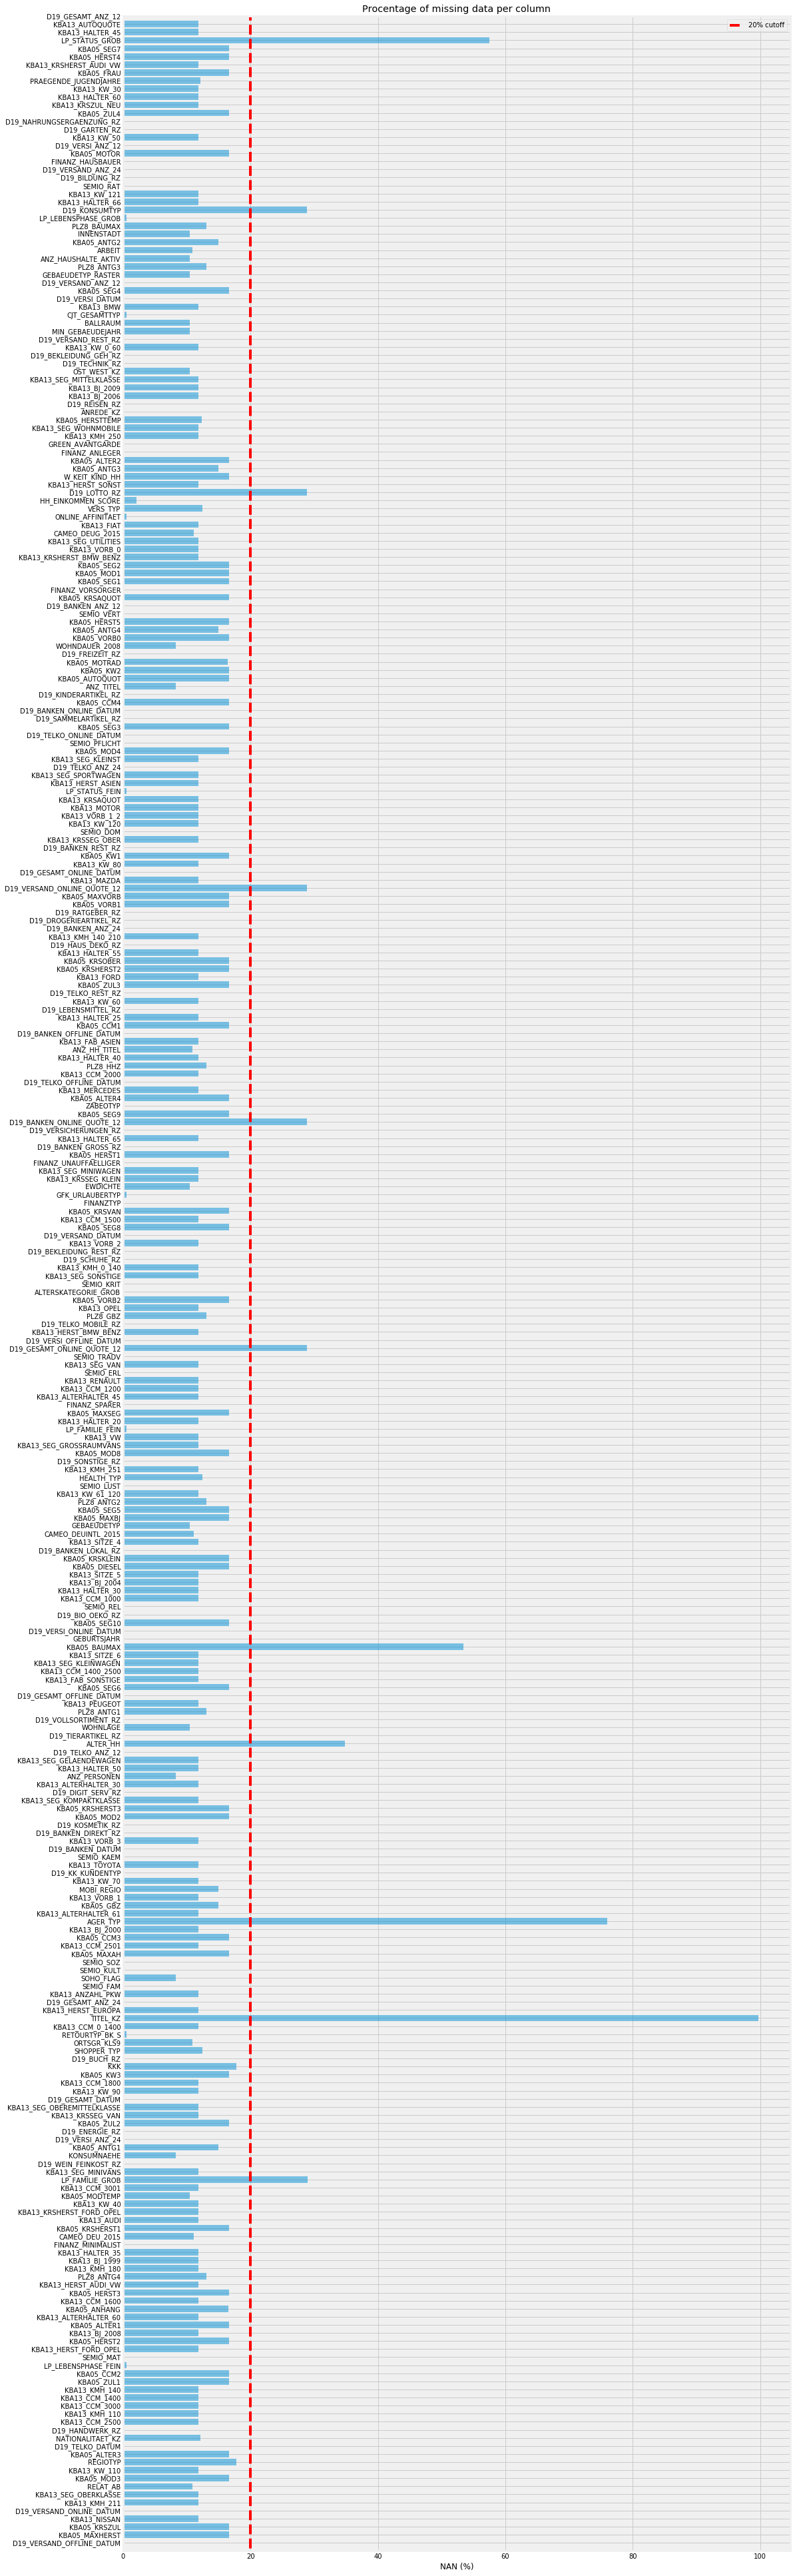

In [60]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(16,70))

y_pos = np.arange(len(col_names_a))
plt.barh(y_pos, nan_values_poc_a, align='center', alpha=0.5)
# visually show which features have more than 20% of missing data
plt.plot([20, 20],[-5, 400],"r--", label="20% cutoff")
plt.ylim(-1,85)
plt.yticks(y_pos, col_names_a)
plt.xlabel('NAN (%)')
plt.title('Procentage of missing data per column')
 
plt.legend()
plt.show()

In [61]:
# count columns with missing values above 20%
_ = nan_values_poc_a[nan_values_poc_a>=20].shape[0]
print(f'There are {_} columns with more than 20% missing values')

There are 11 columns with more than 20% missing values


In [62]:
# Remove the outlier columns from the dataset. 

def remove_nan_collumns(df, limit= 0.2):
    """
    Input:
        limit: float, ratio 
    Output:
        Returns a new dataframe without columns which had more than limit missing data
    """

    no_of_rows = df.shape[0]

    for col_name in df.columns.values:
        # count how many missing values in collumn
        no_of_missing_values = df[col_name].isnull().sum()
        if no_of_missing_values > no_of_rows * limit:
            df = df.drop([col_name], axis=1)
            miss_proc = (no_of_missing_values / no_of_rows) * 100
            print("{:30s} attribute removed, {:.2f} % of data was missing".format(col_name, miss_proc))
            
    return df

In [63]:
%%time
_ = azdias_3.shape
print(f"Before removal Dataframe shape={_} \n")
azdias_4 = remove_nan_collumns(azdias_3)
_ = azdias_4.shape
print(f"\n After removal Dataframe shape={_}")

Before removal Dataframe shape=(891221, 314) 

LP_FAMILIE_GROB                attribute removed, 29.00 % of data was missing
TITEL_KZ                       attribute removed, 99.76 % of data was missing
AGER_TYP                       attribute removed, 76.02 % of data was missing
ALTER_HH                       attribute removed, 34.81 % of data was missing
KBA05_BAUMAX                   attribute removed, 53.47 % of data was missing
D19_GESAMT_ONLINE_QUOTE_12     attribute removed, 28.85 % of data was missing
D19_BANKEN_ONLINE_QUOTE_12     attribute removed, 28.85 % of data was missing
D19_VERSAND_ONLINE_QUOTE_12    attribute removed, 28.85 % of data was missing
D19_LOTTO_RZ                   attribute removed, 28.85 % of data was missing
D19_KONSUMTYP                  attribute removed, 28.85 % of data was missing
LP_STATUS_GROB                 attribute removed, 57.53 % of data was missing

 After removal Dataframe shape=(891221, 303)
Wall time: 31.7 s


In [64]:
nan_sum = azdias_4.isnull().sum().values 

print("{:.2f} % of all data is missing".format(100*np.sum(nan_sum) / (azdias_4.shape[0] * azdias_4.shape[1])))

9.13 % of all data is missing


#### 0.4.2 Investigate missing data in each row

In [65]:
%%time

# create new column which counts how much data is per each row.
# This column will allow us to apply filters on our dataframe
azdias_4["data_count_per_row"] = azdias_4.apply(lambda x: x.count(), axis=1)

Wall time: 2min 7s


In [66]:
# Calculate % of missing data per row (divide number of missing data per round by number of columns)
azdias_4["data_count_per_row"] = azdias_4["data_count_per_row"]/azdias_4.shape[1]*100

In [67]:
print(azdias_4["data_count_per_row"].max()-azdias_4["data_count_per_row"].min())

70.06578947368422


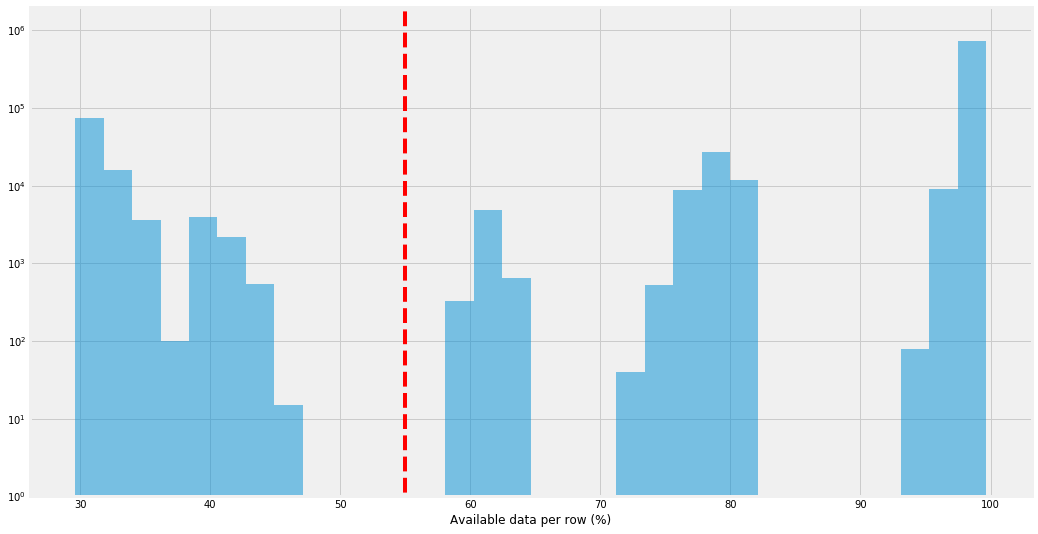

In [68]:
plt.figure(figsize=(16,9))
azdias_4["data_count_per_row"].hist(bins=32, log=True, alpha=0.5);
plt.xlabel("Available data per row (%)");
plt.plot([55, 55],[0, 2e6],"r--");
plt.ylim(1, 2e6);

In [69]:
# drop rows with more less than 55% of data available, i.e. filter out rows with more than 55% available data
azdias_5 = azdias_4[azdias_4["data_count_per_row"] > 55]

# delete "data_count_per_row" column (it messes up all missing data calculations)
del azdias_5["data_count_per_row"]

# reset index
azdias_5 = azdias_5.reset_index(drop=True)

In [70]:
nan_sum = azdias_5.isnull().sum().values 

print("{:.2f} % of all data is missing".format(100*np.sum(nan_sum) / (azdias_5.shape[0] * azdias_5.shape[1])))

1.72 % of all data is missing


In [71]:
# how many rows (%)were droped?
print((azdias_4.shape[0] - azdias_5.shape[0])/azdias_5.shape[0]*100)

12.635419668269208


#### 0.4.3 Do same procedures on `customers` DataFrame

In [72]:
%%time
# get column name array
col_names_c = customers_3.columns.values
# count NAN values in each collumn
nan_values_c = customers_3.isnull().sum().values
# count procentage of each nan value
nan_values_poc_c = nan_values_c / customers_3.shape[0] * 100

Wall time: 4.3 s


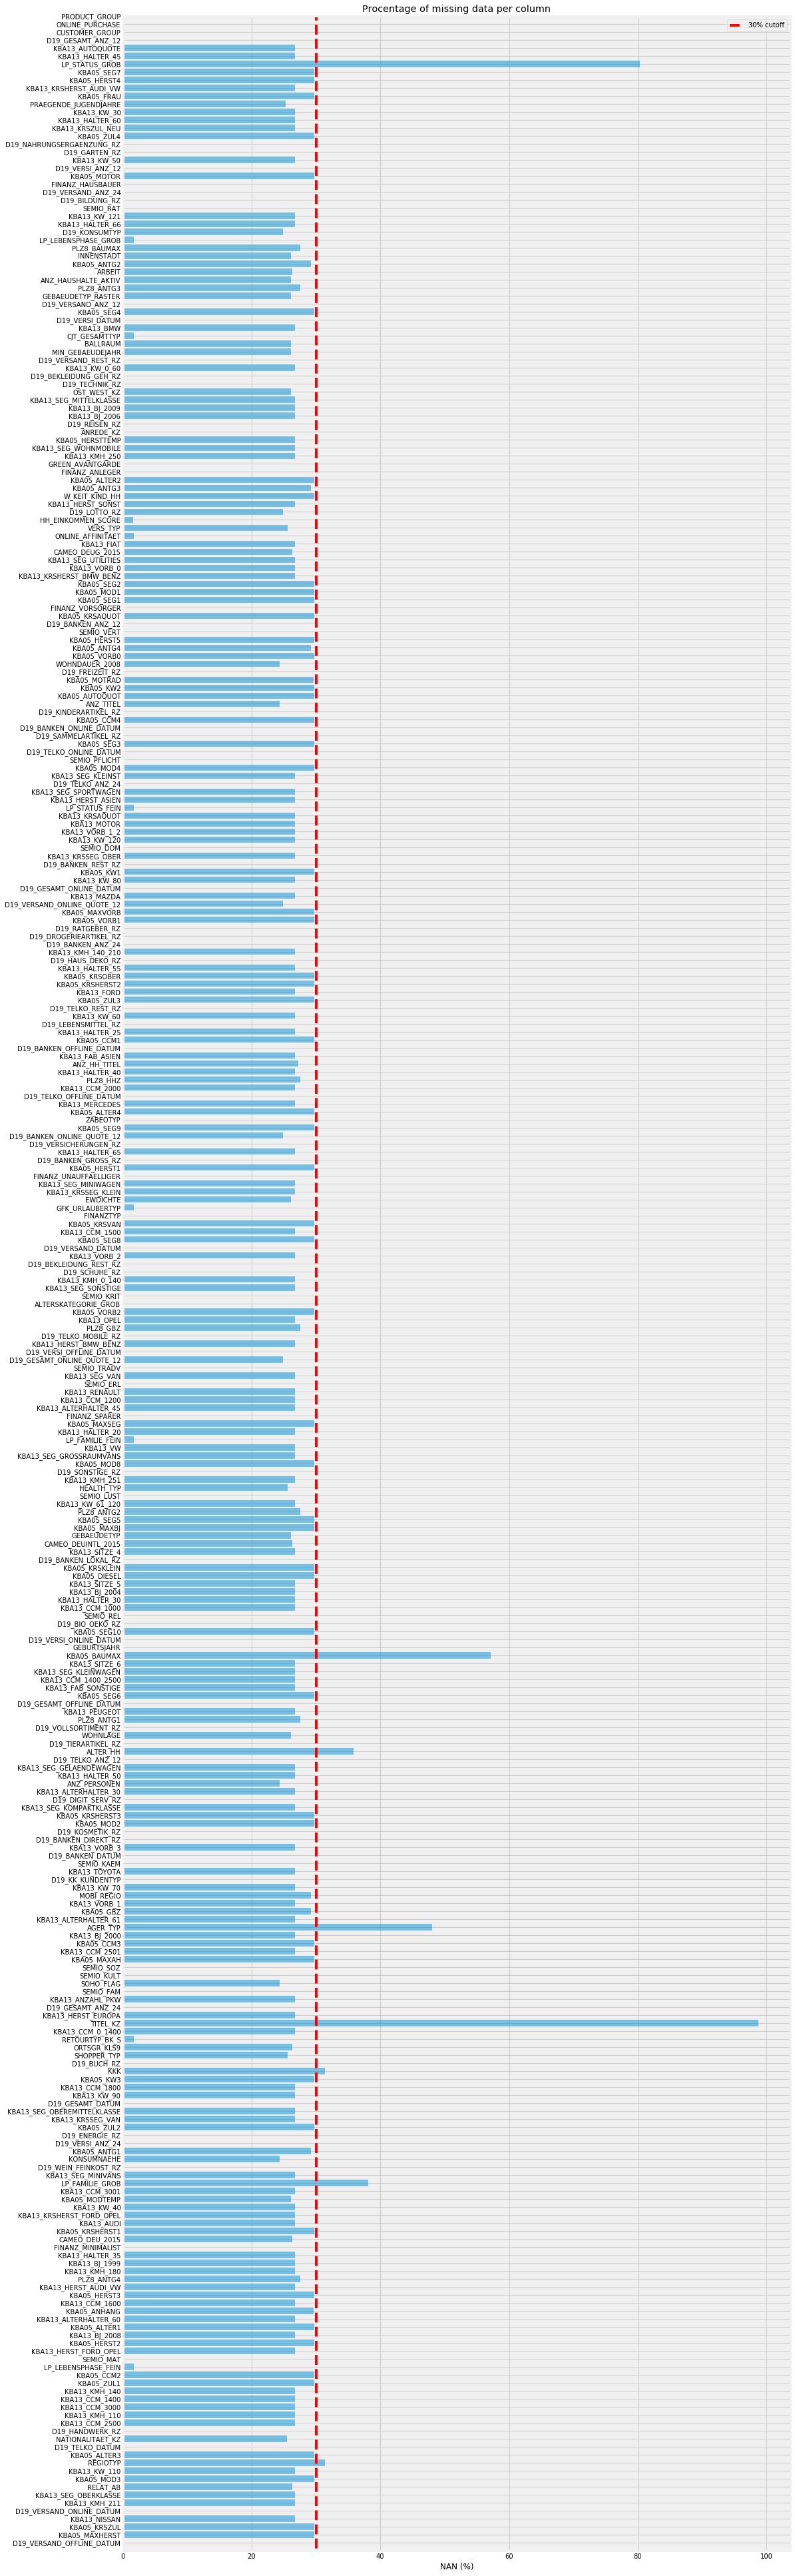

In [73]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(16,70))

y_pos = np.arange(len(col_names_c))
plt.barh(y_pos, nan_values_poc_c, align='center', alpha=0.5)
# visually show which features have more than 20% of missing data
plt.plot([30,30],[-5, 400],"r--", label="30% cutoff")
plt.ylim(-1,85)
plt.yticks(y_pos, col_names_c)
plt.xlabel('NAN (%)')
plt.title('Procentage of missing data per column')
 
plt.legend()
plt.show()

In [74]:
# count columns with missing vlaues above 20%
_ = nan_values_poc_c[nan_values_poc_c>30].shape[0]
print(f'There are {_} columns with more than 30% missing values')

There are 8 columns with more than 30% missing values


Larger cutoff range was used for `customers` DataFrame (30% instead of 20%), because from visual inspections it looks like there is number of users which are missing information in same columns. I will fix them by removing rows instead of columns. 

In [75]:
%%time
_ = customers_3.shape
print(f"Before removal Dataframe shape={_} \n")
customers_4 = remove_nan_collumns(customers_3, limit= 0.3)
_ = customers_4.shape
print(f"\n After removal Dataframe shape={_}")

Before removal Dataframe shape=(191652, 317) 

REGIOTYP                       attribute removed, 31.34 % of data was missing
LP_FAMILIE_GROB                attribute removed, 38.08 % of data was missing
KKK                            attribute removed, 31.34 % of data was missing
TITEL_KZ                       attribute removed, 98.79 % of data was missing
AGER_TYP                       attribute removed, 48.06 % of data was missing
ALTER_HH                       attribute removed, 35.87 % of data was missing
KBA05_BAUMAX                   attribute removed, 57.15 % of data was missing
LP_STATUS_GROB                 attribute removed, 80.30 % of data was missing

 After removal Dataframe shape=(191652, 309)
Wall time: 5.34 s


In [76]:
# create new column which counts how much data is per each row.
# This column will allow us to apply filters on our dataframe
customers_4["data_count_per_row"] = customers_4.apply(lambda x: x.count(), axis=1)
# Calculate % of missing data per row (divide number of missing data per round by number of columns)
customers_4["data_count_per_row"] = customers_4["data_count_per_row"]/customers_4.shape[1]*100

In [77]:
print(customers_4["data_count_per_row"].max()-customers_4["data_count_per_row"].min())

68.38709677419355


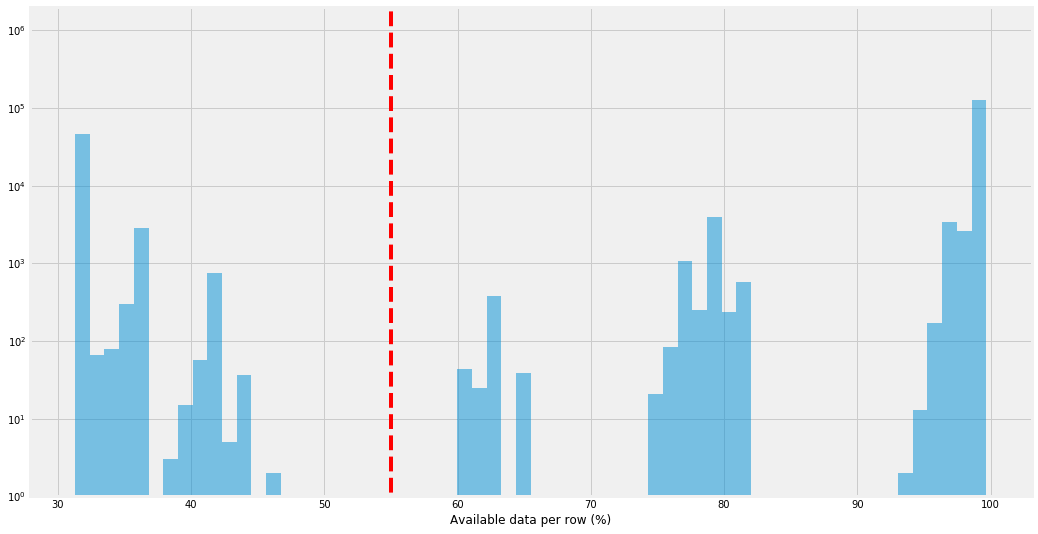

In [78]:
plt.figure(figsize=(16,9))
customers_4["data_count_per_row"].hist(bins=62, log=True, alpha=0.5);
plt.xlabel("Available data per row (%)");
plt.plot([55, 55],[0, 2e6],"r--");
plt.ylim(1, 2e6);

In [79]:
# drop rows with more less than 55% of data available, i.e. filter out rows with more than 55% available data
customers_5 = customers_4[customers_4["data_count_per_row"] > 55]

# delete "data_count_per_row" column (it messes up all missing data calculations)
del customers_5["data_count_per_row"]

# reset index
customers_5 = customers_5.reset_index(drop=True)

In [80]:
# how many rows (%)were droped?
print((customers_4.shape[0] - customers_5.shape[0])/customers_5.shape[0]*100)

36.05463425715584


In [81]:
nan_sum = customers_5.isnull().sum().values 

print("{:.2f} % of all data is missing".format(100*np.sum(nan_sum) / (customers_5.shape[0] * customers_5.shape[1])))

1.15 % of all data is missing


In [82]:
# calculate how much intial Data was droped after removing missing values
# for azdias DataFrame
size_a_before = azdias.shape[0] * azdias.shape[1]
size_a_after = azdias_5.shape[0] * azdias_5.shape[1]
data_droped_a = 100 - size_a_after/size_a_before*100

print(f"{data_droped_a:.2f}% of initial azdias data was droped")


# for customer DataFrame
size_c_before = customers.shape[0] * customers.shape[1]
size_c_after = customers_5.shape[0] * customers_5.shape[1]
data_droped_c = 100 - size_c_after/size_c_before*100

print(f"{data_droped_c:.2f}% of initial customers data was droped")

26.50% of initial azdias data was droped
38.45% of initial customers data was droped


### 0.5 Encode data

Before proceding, identify columns which are unique to `azdias` and `customers` DataFrames.

In [83]:
azdias_col_names = set(azdias_5.columns)
customers_col_names = set(customers_5.columns)

In [84]:
customers_col_names.difference(azdias_col_names)

{'CUSTOMER_GROUP',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LOTTO_RZ',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'ONLINE_PURCHASE',
 'PRODUCT_GROUP'}

In [85]:
azdias_col_names.difference(customers_col_names)

{'KKK', 'REGIOTYP'}

#### 0.5.1 numeric data

Let's first identify which columns contain numeric data. For this let's how many meanings each attribute contains. While iterating of meanings, check if meanings list contains words **"numeric value"**.

In [86]:
_data_1 = list()
_data_2 = list()

for _ in df_attr_p.Meanings:
    # if meanings value is not not, then it is list
    if isinstance(_, list):
        _data_1.append(len(_))
        numeric = 0
        for i in _:
            if i is np.nan:
                pass
            elif "numeric value" in i:
                numeric = 1
                break
        _data_2.append(numeric)
    else:
        _data_1.append(0)
        _data_2.append(np.nan)
        
df_attr_p["no_of_meanings"] = pd.Series(_data_1)  
df_attr_p["numeric_value"] = pd.Series(_data_1)

print(f'max number of meanings {df_attr_p.no_of_meanings.max()}')

max number of meanings 44


In [132]:
# find all numeric columns
numeric_col_names = list(df_attr_p[df_attr_p.numeric_value == 1].Attribute.values)
df_attr_p[df_attr_p.numeric_value == 1]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype,no_of_meanings,numeric_value
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN,[],float64,1,1
5,ANZ_HH_TITEL,number of academic title holder in building,[…],[numeric value (typically coded from 1-10)],NaN,number of holders of an academic title in the ...,NaN,[],float64,1,1
6,ANZ_PERSONEN,number of adult persons in the household,[…],[numeric value (typically coded from 1-3)],NaN,number of persons known in this household,NaN,[],float64,1,1
7,ANZ_TITEL,number of professional title holder in household,[…],[numeric value (typically coded from 1-10)],NaN,number of bearers of an academic title within ...,NaN,[],float64,1,1
84,GEBURTSJAHR,year of birth,[…],[numeric value],NaN,year of birth,NaN,[],int64,1,1
159,KBA13_ANZAHL_PKW,number of cars in the PLZ8,[…],[numeric value],NaN,number of cars in the PLZ8,NaN,[],float64,1,1
271,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...,[…],[numeric value],NaN,year the building was first mentioned in our d...,NaN,[],float64,1,1


In [88]:
# save attr DataFrame for future use

df_attr_p.to_csv('info_attributes_processed.csv', sep=',')

#### 0.5.2 encode binary categorical data

My definition of binary categorical data is object is either True or False. These type of columns will not require one-hot-encoding. 

Because meanings lists can also contain "unknow", "none", folowing 2 cases could be used to find binary categorical data.

In [ ]:
df_attr_p[df_attr_p.no_of_meanings == 0]

In [ ]:
df_attr_p[df_attr_p.no_of_meanings == 1]

In [89]:
df_attr_p[df_attr_p.no_of_meanings == 2]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype,no_of_meanings,numeric_value
86,GREEN_AVANTGARDE,Green avantgarde,"[0, 1]","[doesn't belong to the green avantgarde, belon...",NaN,the environmental sustainability is the domina...,own typology based on modelled on different AZ...,[],int64,2,2


In [90]:
# 'GREEN_AVANTGARDE' column contains binary categorical data
for col in df_attr_p[df_attr_p.no_of_meanings == 2].Attribute:
    print(f"{col} column has unique {azdias_5[col].unique()} values")

GREEN_AVANTGARDE column has unique [0 1] values


In [91]:
# add `` to binary_categorical_col names
binary_categorical_col_names = list()
binary_categorical_col_names.append('GREEN_AVANTGARDE')

In [92]:
df_attr_p[df_attr_p.no_of_meanings ==3]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype,no_of_meanings,numeric_value
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]",NaN,gender,NaN,"[-1, 0]",int64,3,3
144,KBA05_SEG6,share of upper class cars (BMW 7er etc.) in th...,"[-1, 9, 0, 1]","[unknown, none, some]",NaN,share of upper class cars (BMW 7er etc.) in th...,NaN,"[-1, 9]",float64,3,3
276,OST_WEST_KZ,flag indicating the former GDR/FRG,"[-1, O, W]","[unknown, East (GDR), West (FRG)]",NaN,flag indicating the former GDR/FRG,NaN,[-1],object,3,3
303,SOHO_FLAG,small office/home office flag,"[-1, 0, 1]","[unknown, no small office/home office, small o...",NaN,small office/home office flag,NaN,[-1],float64,3,3
305,VERS_TYP,insurance typology,"[-1, 1, 2]","[unknown, social-safety driven, individualisti...",NaN,insurance typology,in cooperation with TNS Infratest,[-1],int64,3,3


In [93]:
# investigate unique values in each column
for col in df_attr_p[df_attr_p.no_of_meanings == 3].Attribute:
    print(f"{col:15s} column has unique {azdias_5[col].unique()} values")

ANREDE_KZ       column has unique [2 1] values
KBA05_SEG6      column has unique [ 1.  0. nan] values
OST_WEST_KZ     column has unique ['W' 'O'] values
SOHO_FLAG       column has unique [1. 0.] values
VERS_TYP        column has unique [ 2.  1. nan] values


In [94]:
# rename 2's with zeros, to have binary encoded data
azdias_5.loc[:, "ANREDE_KZ"] = azdias_5["ANREDE_KZ"].replace({2: 0})
azdias_5.loc[:, "VERS_TYP"] = azdias_5["VERS_TYP"].replace({2: 0})
# rename west 'W' with 0 and east 'O' with 1
azdias_5.loc[:, "OST_WEST_KZ"] = azdias_5["OST_WEST_KZ"].replace({'W': 0, 'O': 1})

In [95]:
# make same procedures with customers dataframe
customers_5.loc[:, "ANREDE_KZ"] = customers_5["ANREDE_KZ"].replace({2: 0})
customers_5.loc[:, "VERS_TYP"] = customers_5["VERS_TYP"].replace({2: 0})
customers_5.loc[:, "OST_WEST_KZ"] = customers_5["OST_WEST_KZ"].replace({'W': 0, 'O': 1})

In [96]:
# investigate unique values in each column
for col in df_attr_p[df_attr_p.no_of_meanings == 3].Attribute:
    print(f"{col:15s} column has unique {azdias_5[col].unique()} values")
    # add col_names
    binary_categorical_col_names.append(col)

ANREDE_KZ       column has unique [0 1] values
KBA05_SEG6      column has unique [ 1.  0. nan] values
OST_WEST_KZ     column has unique [0 1] values
SOHO_FLAG       column has unique [1. 0.] values
VERS_TYP        column has unique [ 0.  1. nan] values


In [97]:
# all binary categorical columns
binary_categorical_col_names

['GREEN_AVANTGARDE',
 'ANREDE_KZ',
 'KBA05_SEG6',
 'OST_WEST_KZ',
 'SOHO_FLAG',
 'VERS_TYP']

#### Ordinal data
I couldn't find a good way to identify ordinal data (apart manually scanning `.xlsx` files), thus I chose to treat all remaining data as categorical.

#### 0.5.3 check for columns with "rough" and "detailed" scales

From previous project "Unsupervised Learning" I remmeber that `azdias` DataFrame contailed dublicate data, i.e. same information provided in rough or detailed scales. In cells bellow I identified these columns in both DataFrames.

In [98]:
for col in azdias_5.columns:
    if col[-5:] == "_FEIN" or col[-5:] == "_GROB":
        print(col)

LP_LEBENSPHASE_FEIN
LP_FAMILIE_FEIN
ALTERSKATEGORIE_GROB
LP_STATUS_FEIN
LP_LEBENSPHASE_GROB


In [99]:
for col in customers_5.columns:
    if col[-5:] == "_FEIN" or col[-5:] == "_GROB":
        print(col)

LP_LEBENSPHASE_FEIN
LP_FAMILIE_FEIN
ALTERSKATEGORIE_GROB
LP_STATUS_FEIN
LP_LEBENSPHASE_GROB


In [100]:
print("LP_LEBENSPHASE_FEIN has {:.2f} % missing data in azdias DataFrame".format(azdias_5.LP_LEBENSPHASE_FEIN.isnull().sum() / azdias_5.shape[0] * 100))
print("LP_LEBENSPHASE_GROB has {:.2f} % missing data in azdias DataFrame".format(azdias_5.LP_LEBENSPHASE_GROB.isnull().sum() / azdias_5.shape[0] * 100))

LP_LEBENSPHASE_FEIN has 0.59 % missing data in azdias DataFrame
LP_LEBENSPHASE_GROB has 0.59 % missing data in azdias DataFrame


In [101]:
print("LP_LEBENSPHASE_FEIN has {:.2f} % missing data in customers DataFrame".format(customers_5.LP_LEBENSPHASE_FEIN.isnull().sum() / customers_5.shape[0] * 100))
print("LP_LEBENSPHASE_GROB has {:.2f} % missing data in customers DataFrame".format(customers_5.LP_LEBENSPHASE_GROB.isnull().sum() / customers_5.shape[0] * 100))

LP_LEBENSPHASE_FEIN has 2.21 % missing data in customers DataFrame
LP_LEBENSPHASE_GROB has 2.21 % missing data in customers DataFrame


Only `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` had duplicate entires. It seems that rows contain equal information about both attributes, therefore I decided to drop rough scale `LP_LEBENSPHASE_GROB ` column.

In [102]:
azdias_5 = azdias_5.drop(["LP_LEBENSPHASE_GROB"], axis=1)
customers_5 = customers_5.drop(["LP_LEBENSPHASE_GROB"], axis=1)

#### `CAMEO_DEU_2015` quick fix.

I found this accidently by checking which columns have more meanings than maximum number of meanings. Out of 4 columns, 3 were numeric and `CAMEO_DEU_2015` after additional investigation, I found that 'XX' should be renamed with NAN.

In [103]:
max_no_of_meanings = df_attr_p.no_of_meanings.max()

for col in azdias_5.columns:
    # count unqiue values
    _data.append(azdias_5[col].nunique())
    if azdias_5[col].nunique() > max_no_of_meanings:
        print(col)

CAMEO_DEU_2015
KBA13_ANZAHL_PKW
GEBURTSJAHR
ANZ_HAUSHALTE_AKTIV


In [104]:
azdias_5["CAMEO_DEU_2015"].unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

It seems that column `CAMEO_DEU_2015` contains missing values marked as 'XX'. It is safe to say, that it needs to be replaced with NAN value.

In [105]:
# rename "XX" with np.nan
azdias_5["CAMEO_DEU_2015"] = azdias_5["CAMEO_DEU_2015"].replace("XX", np.nan)
customers_5["CAMEO_DEU_2015"] = customers_5["CAMEO_DEU_2015"].replace("XX", np.nan)

In [106]:
azdias_5["CAMEO_DEU_2015"].unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

#### `CAMEO_DEUINTL_2015` quick fix.

I also found that contains some missing values enotated with 'XX'.

In [107]:
azdias_5["CAMEO_DEUINTL_2015"].unique() 

array([51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0,
       34.0, 55.0, 25.0, nan, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [108]:
# rename "XX" with np.nan
azdias_5["CAMEO_DEUINTL_2015"] = azdias_5["CAMEO_DEUINTL_2015"].replace("XX", np.nan)
customers_5["CAMEO_DEUINTL_2015"] = customers_5["CAMEO_DEUINTL_2015"].replace("XX", np.nan)

In [109]:
azdias_5["CAMEO_DEUINTL_2015"].unique() 

array([51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0,
       34.0, 55.0, 25.0, nan, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45'],
      dtype=object)

It seems that some values are notated as strings while others as floats. These numbers should be normalized.

In [144]:
azdias_5["CAMEO_DEUINTL_2015"] = azdias_5["CAMEO_DEUINTL_2015"].astype('float')
customers_5["CAMEO_DEUINTL_2015"] = customers_5["CAMEO_DEUINTL_2015"].astype('float')
azdias_5["CAMEO_DEUINTL_2015"].unique() 

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34., 55.,
       25., nan, 23., 31., 52., 35., 45., 44., 32.])

#### 0.5.4 Categorical data one-hot-encoding

From previous *unsupervided learning* project **5** columns with mixed-type features were indentified. This means that all remaing features (excluding numeric, binary categorical and mixed-type features) should be categorical data, i.e. one-hot encoded.

In [148]:
mixed_col_names = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_DEUINTL_2015", "LP_LEBENSPHASE_FEIN", "WOHNLAGE", "PLZ8_BAUMAX"]
# create DataFrame copies for one-hot encoding
azdias_6 = azdias_5.copy()
customers_6 = customers_5.copy()

In [161]:
# get NOT categorical data column names for azdias DataFrame
not_cat_col_names_a = numeric_col_names + binary_categorical_col_names + mixed_col_names

In [162]:
# get categorical data column names
cat_col_names_a = set(azdias_6.columns).difference(set(not_cat_col_names))

In [168]:
azdias_cat = azdias_6[list(cat_col_names_a)]

In [167]:
# do same procedure for customers DataFrame

# get NOT categorical data column names for customers DataFrame
not_cat_col_names_c = numeric_col_names + binary_categorical_col_names + mixed_col_names
# get categorical data column names for customers DataFrame
cat_col_names_c = set(customers_6.columns).difference(set(not_cat_col_names))
customers_cat =  customers_6[list(cat_col_names_c)]

#### One-hot-encode categorical features


In [172]:
%%time

# create temporary copy of DataFrame with only categorical data
_df = azdias_cat.copy()

# iterate over columns
for _ in _df.columns:
    # one-one-hot encode the feature and add it to the dataframe
    _df = _df.join(pd.get_dummies(_df[_], prefix=_))
    # drop feature from data
    _df = _df.drop([_], axis=1)
    print("{:30s} feature one-hot-encoded".format(_))    

KBA05_KRSZUL         feature one-hot-encoded
KBA13_NISSAN         feature one-hot-encoded
D19_VERSAND_ONLINE_DATUM feature one-hot-encoded
KBA13_KMH_211        feature one-hot-encoded
KBA13_SEG_OBERKLASSE feature one-hot-encoded
RELAT_AB             feature one-hot-encoded
KBA13_CCM_2500       feature one-hot-encoded
KBA13_CCM_1400       feature one-hot-encoded
KBA05_CCM2           feature one-hot-encoded
KBA05_ALTER1         feature one-hot-encoded
KBA13_ALTERHALTER_60 feature one-hot-encoded
KBA13_CCM_1600       feature one-hot-encoded
PLZ8_ANTG4           feature one-hot-encoded
KBA05_HERST3         feature one-hot-encoded
KBA13_HERST_AUDI_VW  feature one-hot-encoded
KBA13_KMH_180        feature one-hot-encoded
KBA13_BJ_1999        feature one-hot-encoded
CAMEO_DEU_2015       feature one-hot-encoded
KBA05_KRSHERST1      feature one-hot-encoded
KBA13_AUDI           feature one-hot-encoded
KBA13_KW_40          feature one-hot-encoded
KBA13_SEG_MINIVANS   feature one-hot-encoded
KONSUM

KBA05_MOD2           feature one-hot-encoded
KBA13_ALTERHALTER_30 feature one-hot-encoded
KBA13_HALTER_50      feature one-hot-encoded
D19_TELKO_ANZ_12     feature one-hot-encoded
D19_VOLLSORTIMENT_RZ feature one-hot-encoded
PLZ8_ANTG1           feature one-hot-encoded
KBA13_PEUGEOT        feature one-hot-encoded
KBA13_SITZE_6        feature one-hot-encoded
SEMIO_REL            feature one-hot-encoded
D19_BIO_OEKO_RZ      feature one-hot-encoded
KBA13_BJ_2004        feature one-hot-encoded
KBA05_MAXBJ          feature one-hot-encoded
GEBAEUDETYP          feature one-hot-encoded
PLZ8_ANTG2           feature one-hot-encoded
SEMIO_LUST           feature one-hot-encoded
KBA13_KMH_251        feature one-hot-encoded
D19_SONSTIGE_RZ      feature one-hot-encoded
KBA05_MOD8           feature one-hot-encoded
KBA13_HALTER_20      feature one-hot-encoded
KBA05_MAXSEG         feature one-hot-encoded
SEMIO_TRADV          feature one-hot-encoded
KBA13_RENAULT        feature one-hot-encoded
KBA13_CCM_

In [173]:
# join temporary DataFrame with azdias DataFrame
azdias_7 = azdias_6[list(not_cat_col_names_a)].join(_df)
print(azdias_6.shape)
print(azdias_7.shape)

(791244, 302)
(791244, 1758)


Make same procedure for `customers` DataFrame.

In [177]:
%%time

# create temporary copy of DataFrame with only categorical data
_df = customers_cat.copy()

# iterate over columns
for _ in _df.columns:
    # one-one-hot encode the feature and add it to the dataframe
    _df = _df.join(pd.get_dummies(_df[_], prefix=_))
    # drop feature from data
    _df = _df.drop([_], axis=1)
    print("{:30s} feature one-hot-encoded".format(_))    

KBA05_KRSZUL                   feature one-hot-encoded
KBA13_NISSAN                   feature one-hot-encoded
D19_VERSAND_ONLINE_DATUM       feature one-hot-encoded
KBA13_KMH_211                  feature one-hot-encoded
KBA13_SEG_OBERKLASSE           feature one-hot-encoded
RELAT_AB                       feature one-hot-encoded
KBA13_CCM_2500                 feature one-hot-encoded
KBA13_CCM_1400                 feature one-hot-encoded
KBA05_CCM2                     feature one-hot-encoded
KBA05_ALTER1                   feature one-hot-encoded
KBA13_ALTERHALTER_60           feature one-hot-encoded
KBA13_CCM_1600                 feature one-hot-encoded
PLZ8_ANTG4                     feature one-hot-encoded
KBA05_HERST3                   feature one-hot-encoded
KBA13_HERST_AUDI_VW            feature one-hot-encoded
KBA13_KMH_180                  feature one-hot-encoded
KBA13_BJ_1999                  feature one-hot-encoded
CAMEO_DEU_2015                 feature one-hot-encoded
KBA05_KRSH

KBA13_KMH_140                  feature one-hot-encoded
KBA13_KMH_110                  feature one-hot-encoded
KBA13_CCM_3000                 feature one-hot-encoded
KBA05_ZUL1                     feature one-hot-encoded
SEMIO_MAT                      feature one-hot-encoded
KBA13_HERST_FORD_OPEL          feature one-hot-encoded
KBA05_HERST2                   feature one-hot-encoded
KBA13_BJ_2008                  feature one-hot-encoded
KBA05_ANHANG                   feature one-hot-encoded
KBA13_HALTER_35                feature one-hot-encoded
FINANZ_MINIMALIST              feature one-hot-encoded
KBA13_KRSHERST_FORD_OPEL       feature one-hot-encoded
KBA05_MODTEMP                  feature one-hot-encoded
KBA13_CCM_3001                 feature one-hot-encoded
D19_WEIN_FEINKOST_RZ           feature one-hot-encoded
D19_VERSI_ANZ_24               feature one-hot-encoded
D19_ENERGIE_RZ                 feature one-hot-encoded
KBA05_ZUL2                     feature one-hot-encoded
KBA13_SEG_

In [178]:
# join temporary DataFrame with azdias DataFrame
customers_7 = customers_6[list(not_cat_col_names_c)].join(_df)
print(customers_6.shape)
print(customers_7.shape)

(140864, 308)
(140864, 1793)


#### 0.5.5 One-hot-encode mixed-type features

Last 5 columns with mixed type features will be manually processed (see cells below).

In [124]:
# create DataFrame copies for one-hot encoding
azdias_8 = azdias_7.copy()
customers_8 = customers_7.copy()

##### 0.5.5.1 `PRAEGENDE_JUGENDJAHRE`

`PRAEGENDE_JUGENDJAHRE` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

In [125]:
# investigate "PRAEGENDE_JUGENDJAHRE" mixed meanings

_values = df_attr_p[df_attr_p.Attribute == "PRAEGENDE_JUGENDJAHRE"].Values.values[0]
_meanings = df_attr_p[df_attr_p.Attribute == "PRAEGENDE_JUGENDJAHRE"].Meanings.values[0]

for _ in range(len(_meanings)):
    print(f"{_values[_]}: {_meanings[_]}")

-1, 0: unknown
1: 40ies - war years (Mainstream, O+W)
2: 40ies - reconstruction years (Avantgarde, O+W)
3: 50ies - economic miracle (Mainstream, O+W)
4: 50ies - milk bar / Individualisation (Avantgarde, O+W)
5: 60ies - economic miracle (Mainstream, O+W)
6: 60ies - generation 68 / student protestors (Avantgarde, W)
7: 60ies - opponents to the building of the Wall (Avantgarde, O)
8: 70ies - family orientation (Mainstream, O+W)
9: 70ies - peace movement (Avantgarde, O+W)
10: 80ies - Generation Golf (Mainstream, W)
11: 80ies - ecological awareness (Avantgarde, W)
12: 80ies - FDJ / communist party youth organisation (Mainstream, O)
13: 80ies - Swords into ploughshares (Avantgarde, O)
14: 90ies - digital media kids (Mainstream, O+W)
15: 90ies - ecological awareness (Avantgarde, O+W)


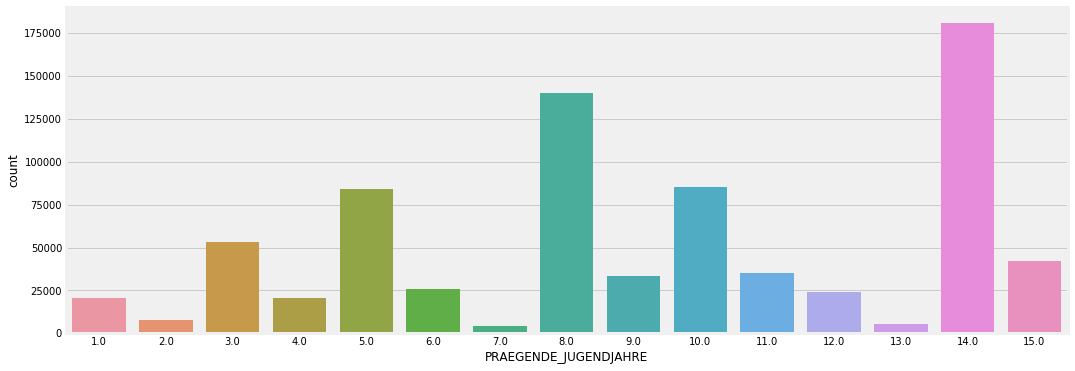

In [126]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables and visualize
plt.figure(figsize=(16, 6))
sns.countplot(x="PRAEGENDE_JUGENDJAHRE", data=azdias_8);

In [127]:
# replace NAN values with 0s, so that dictonary mapping could be used
# e.g. {np.nan: [np.nan, np.nan]} doesn't work.
azdias_8.PRAEGENDE_JUGENDJAHRE = azdias_8.PRAEGENDE_JUGENDJAHRE.fillna(0)
azdias_8.PRAEGENDE_JUGENDJAHRE = azdias_8.PRAEGENDE_JUGENDJAHRE.fillna(0)

# manual dictonary was created to encode diffent values to different collumn
PRAEGENDE_JUGENDJAHRE_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["40s", 0],
    2.0: ["40s", 1],
    3.0: ["50s", 0],
    4.0: ["50s", 1],
    5.0: ["60s", 0],
    6.0: ["60s", 1],
    7.0: ["60s", 1],
    8.0: ["70s", 0],
    9.0: ["70s", 1],
    10.0: ["80s", 0],
    11.0: ["80s", 1],
    12.0: ["80s", 0],
    13.0: ["80s", 1],
    14.0: ["90s", 0],
    15.0: ["90s", 1]
}

In [128]:
%%time
# create new columns for decade and movement values
_ = azdias_8.PRAEGENDE_JUGENDJAHRE.apply(lambda s: pd.Series({
    'PRAEGENDE_JUGENDJAHRE_decade':PRAEGENDE_JUGENDJAHRE_dict[s][0],
    'PRAEGENDE_JUGENDJAHRE_movement':PRAEGENDE_JUGENDJAHRE_dict[s][1]}))

# add these columns to data frame
azdias_8 = azdias_8.merge(_, left_index=True, right_index=True)
# drop PRAEGENDE_JUGENDJAHRE column from dataframe
azdias_8 = azdias_8.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1)
# one-hot-encode decade data
azdias_8 = azdias_8.join(pd.get_dummies(azdias_8["PRAEGENDE_JUGENDJAHRE_decade"],
                                                prefix="PRAEGENDE_JUGENDJAHRE_decade"))
# drop "PRAEGENDE_JUGENDJAHRE_decade" column
azdias_8 = azdias_8.drop(["PRAEGENDE_JUGENDJAHRE_decade"], axis=1)

Wall time: 6min 55s


Apply same steps to `customers` DataFrame.

In [129]:
%%time
# create new columns for decade and movement values
_ = customers_8.PRAEGENDE_JUGENDJAHRE.apply(lambda s: pd.Series({
    'PRAEGENDE_JUGENDJAHRE_decade':PRAEGENDE_JUGENDJAHRE_dict[s][0],
    'PRAEGENDE_JUGENDJAHRE_movement':PRAEGENDE_JUGENDJAHRE_dict[s][1]}))

# add these columns to data frame
customers_8 = customers_8.merge(_, left_index=True, right_index=True)
# drop PRAEGENDE_JUGENDJAHRE column from dataframe
customers_8 = customers_8.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1)
# one-hot-encode decade data
customers_8 = customers_8.join(pd.get_dummies(customers_8["PRAEGENDE_JUGENDJAHRE_decade"],
                                                prefix="PRAEGENDE_JUGENDJAHRE_decade"))
# drop "PRAEGENDE_JUGENDJAHRE_decade" column
customers_8 = customers_8.drop(["PRAEGENDE_JUGENDJAHRE_decade"], axis=1)

Wall time: 1min 17s


##### 0.5.5.1 `CAMEO_DEUINTL_2015`

`CAMEO_DEUINTL_2015` combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values). 

**Quick comment**: in unsupervised learning project this feature was `CAMEO_INTL_2015`. In this project `CAMEO_INTL_2015` was renamed to `CAMEO_DEUINTL_2015` to match column notation in `.xlsx` files.

In [130]:
# investigate "PRAEGENDE_JUGENDJAHRE" mixed meanings

_values = df_attr_p[df_attr_p.Attribute == "CAMEO_DEUINTL_2015"].Values.values[0]
_meanings = df_attr_p[df_attr_p.Attribute == "CAMEO_DEUINTL_2015"].Meanings.values[0]

for _ in range(len(_meanings)):
    print(f"{_values[_]}: {_meanings[_]}")

-1: unknown
11: Wealthy Households-Pre-Family Couples & Singles
12: Wealthy Households-Young Couples With Children
13: Wealthy Households-Families With School Age Children
14: Wealthy Households-Older Families &  Mature Couples
15: Wealthy Households-Elders In Retirement
21: Prosperous Households-Pre-Family Couples & Singles
22: Prosperous Households-Young Couples With Children
23: Prosperous Households-Families With School Age Children
24: Prosperous Households-Older Families & Mature Couples
25: Prosperous Households-Elders In Retirement
31: Comfortable Households-Pre-Family Couples & Singles
32: Comfortable Households-Young Couples With Children
33: Comfortable Households-Families With School Age Children
34: Comfortable Households-Older Families & Mature Couples
35: Comfortable Households-Elders In Retirement
41: Less Affluent Households-Pre-Family Couples & Singles
42: Less Affluent Households-Young Couples With Children
43: Less Affluent Households-Families With School Age Childr

One can see that 10ths indicate wealth, while one's indicate family type:

* **1X** *Wealthy*, **2X** *Prosperous* and ect.
* **X1** *Households-Pre-Family Couples & Singles*, **X2** *Households-Young Couples With Children* and ect.

Information about wealth will be written using function:
```python
lambda x: x//10
```
, while information about famility type use:
```python
lambda x: x%10
```




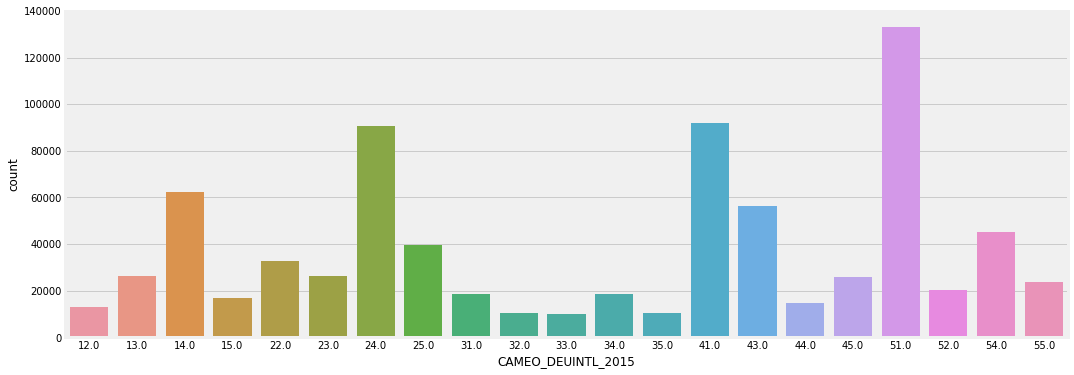

In [131]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables and visualize
plt.figure(figsize=(16, 6))
sns.countplot(x="CAMEO_DEUINTL_2015", data=azdias_8);

In [ ]:
%%time

# create new collumns for decade and movement values
_ = azdias_8.CAMEO_DEUINTL_2015.apply(lambda s: pd.Series({
    'CAMEO_DEUINTL_2015_wealth':s//10,
    'CAMEO_DEUINTL_2015_lifestage':s%10}))
# add these collumns to data frame
azdias_8 = azdias_8.merge(_, left_index=True, right_index=True);
# drop CAMEO_INTL_2015 collumn from dataframe
azdias_8 = azdias_8.drop(["CAMEO_DEUINTL_2015"], axis=1)
# one-hot-encode wealth and lifestage data
azdias_8 = azdias_8.join(pd.get_dummies(azdias_6["CAMEO_DEUINTL_2015_wealth"],
                                                prefix="CAMEO_DEUINTL_2015_wealth"))
azdias_8 = azdias_8.join(pd.get_dummies(azdias_6["CAMEO_DEUINTL_2015_lifestage"],
                                                prefix="CAMEO_DEUINTL_2015_lifestage"))
# drop one-hot-encoded original collumns
azdias_8 = azdias_8.drop(["CAMEO_DEUINTL_2015_wealth"], axis=1)
azdias_8 = azdias_8.drop(["CAMEO_DEUINTL_2015_lifestage"], axis=1)

Make same procedure for `customers` DataFrame.

In [ ]:
# 

_values = df_attr_p[df_attr_p.Attribute == "CAMEO_DEU_2015"].Values.values[0]
_meanings = df_attr_p[df_attr_p.Attribute == "CAMEO_DEU_2015"].Meanings.values[0]

for _ in range(len(_meanings)):
    print(f"{_values[_]}: {_meanings[_]}")

In [ ]:
df_attr_p[df_attr_p.Attribute == col].Meanings

In [ ]:
azdias_5["KBA13_ANZAHL_PKW"].unique()

In [ ]:
# count the largest number of meanings
max_no_meanings = 0

for _ in df_attr_p.Meanings:
    if _ is not np.nan:
        if len(_) > max_no_meanings:
            max_no_meanings = len(_)    
            
print(f"Columns can have maximum of {max_no_meanings} categorical values")

In [ ]:
_ = np.nan
_ is not np.nan

#### 0.5.3 encode mixed data

In [ ]:
(customers_4.shape[0] - customers_5.shape[0])/customers_5.shape[0]

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 0: Main take aways

* In both `azdias` and `customers` DataFrames 52 columns were found unknown, i.e. no meanings could be identified in provided `.xlsx` files. These columns were droped from further analysis. Even though 3 additinal columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP') in `customers` DataFrames were also not present in `.xlsx` files, column names were explicit enought to understand value's meaning. For this reason, these columns were not dropped. 
* Additional **60** columns were droped from `azdias` because they had more than **20%** data missing.
* Additional **59** columns were droped from `customers` because they had more than **30%** data missing. Larger cutoff procentage limit was used, because from visual analysis there there many rows which had **~25%** of missing data in same ammount of columns. Using smaller limit would have resulted in dropping too many columns.
* **12.6%** of rows were droped from from `azdias` because they had more than **55%** missing data. 
* **36%** of rows were droped from from `customers` because they had more than **55%** missing data.
* After these procedures 38.39% and 48.61% of data was droped for initail `azdias` and `customers` DataFrames.
* I found that columns `CAMEO_DEU_2015` and `CAMEO_DEUINTL_2015` contained 'XX' values (value not found in `.xlsx` files). 'XX' were replaced with numpy nan values.
* 2 columns with `_GROB` endings were droped. Such ending provides same information as `_FEIN`, but rough scale.
* 7 columns were found to contain numeric data.
* 5 columns were found to contain binary categorical data.
* X columns had mixed data, custom data concertions were used. 
* Finally one-hot-encoding was carried on clean data:

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 PCA

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train.to_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test.to_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')